In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [146]:
df=pd.read_csv("D:\\metadata.csv")

In [147]:
df.head(10)

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN
5,charge,[2010. 7. 21. 22. 38. ...,4,B0047,5,6,00006.csv,NaN,NaN,NaN
6,discharge,[2.010e+03 7.000e+00 2.200e+01 1.000e+00 4.000...,4,B0047,6,7,00007.csv,1.5080762969973425,NaN,NaN
7,charge,[2010. 7. 22. 3. 14. ...,4,B0047,7,8,00008.csv,NaN,NaN,NaN
8,discharge,[2010. 7. 22. 6. 16. ...,4,B0047,8,9,00009.csv,1.4835577960067696,NaN,NaN
9,charge,[2010. 7. 22. 7. 50. ...,4,B0047,9,10,00010.csv,NaN,NaN,NaN


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   type                 7565 non-null   object
 1   start_time           7565 non-null   object
 2   ambient_temperature  7565 non-null   int64 
 3   battery_id           7565 non-null   object
 4   test_id              7565 non-null   int64 
 5   uid                  7565 non-null   int64 
 6   filename             7565 non-null   object
 7   Capacity             2794 non-null   object
 8   Re                   1956 non-null   object
 9   Rct                  1956 non-null   object
dtypes: int64(3), object(7)
memory usage: 591.1+ KB


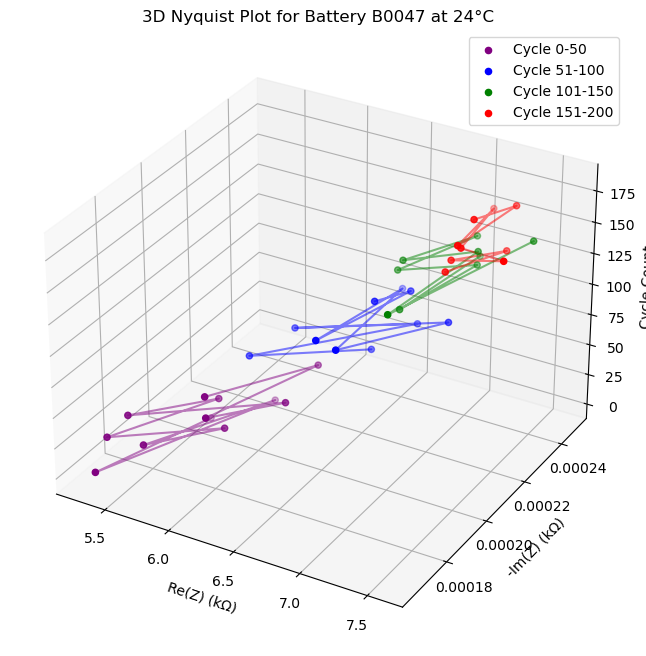

Summary:
- 3D Nyquist plot generated for battery B0047 at 24°C.
- Data grouped by cycle count ranges: 0-50, 51-100, 101-150, 151-200.
- Each curve represents impedance measurements for a cycle count range.
- Re(Z) and -Im(Z) are plotted in kΩ, converted from ohms.
- Trend: Impedance increases with cycle count, indicating battery degradation.


In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def process_data(data):
    try:
        required_columns = ['type', 'ambient_temperature', 'battery_id', 'test_id', 'Re', 'Rct']
        if not all(col in data.columns for col in required_columns):
            raise ValueError("Missing required columns in the dataset.")
        
        filtered_data = data[
            (data['type'] == 'impedance') & 
            (data['ambient_temperature'] == 24) & 
            (data['battery_id'] == 'B0047')
        ].copy()

        filtered_data['test_id'] = pd.to_numeric(filtered_data['test_id'], errors='coerce')
        filtered_data['Re'] = pd.to_numeric(filtered_data['Re'], errors='coerce')
        filtered_data['Rct'] = pd.to_numeric(filtered_data['Rct'], errors='coerce')
        
        filtered_data['Re_kΩ'] = filtered_data['Re'] / 1000
        filtered_data['Im_kΩ'] = filtered_data['Rct'] / 1000

        cleaned_data = filtered_data[['test_id', 'Re_kΩ', 'Im_kΩ']].dropna()
        if cleaned_data.empty:
            raise ValueError("No valid data after filtering.")
        
        return cleaned_data
    
    except Exception as e:
        raise ValueError(f"Error processing data: {str(e)}")

def plot_nyquist(data):
    bins = [0, 50, 100, 150, 200]
    labels = ['0-50', '51-100', '101-150', '151-200']
    data['cycle_range'] = pd.cut(data['test_id'], bins=bins, labels=labels, include_lowest=True)
    
    colors = ['purple', 'blue', 'green', 'red']
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for cycle_range, color in zip(labels, colors):
        subset = data[data['cycle_range'] == cycle_range]
        if not subset.empty:
            ax.scatter(subset['Re_kΩ'], subset['Im_kΩ'], subset['test_id'], c=color, label=f'Cycle {cycle_range}')
            ax.plot(subset['Re_kΩ'], subset['Im_kΩ'], subset['test_id'], c=color, alpha=0.5)
    
    ax.set_xlabel('Re(Z) (kΩ)')
    ax.set_ylabel('-Im(Z) (kΩ)')
    ax.set_zlabel('Cycle Count')
    ax.set_title('3D Nyquist Plot for Battery B0047 at 24°C')
    ax.legend()
    
    plt.savefig('nyquist_3d_plot.png')
    plt.show()

def main(df):
    try:
        data = process_data(df)
        
        plot_nyquist(data)
        
        print("Summary:")
        print("- 3D Nyquist plot generated for battery B0047 at 24°C.")
        print("- Data grouped by cycle count ranges: 0-50, 51-100, 101-150, 151-200.")
        print("- Each curve represents impedance measurements for a cycle count range.")
        print("- Re(Z) and -Im(Z) are plotted in kΩ, converted from ohms.")
        print("- Trend: Impedance increases with cycle count, indicating battery degradation.")
        
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    try:
        main(df)
    except NameError:
        print("Error: DataFrame 'df' is not defined. Please load the data first using df = pd.read_csv('metadata.csv').")

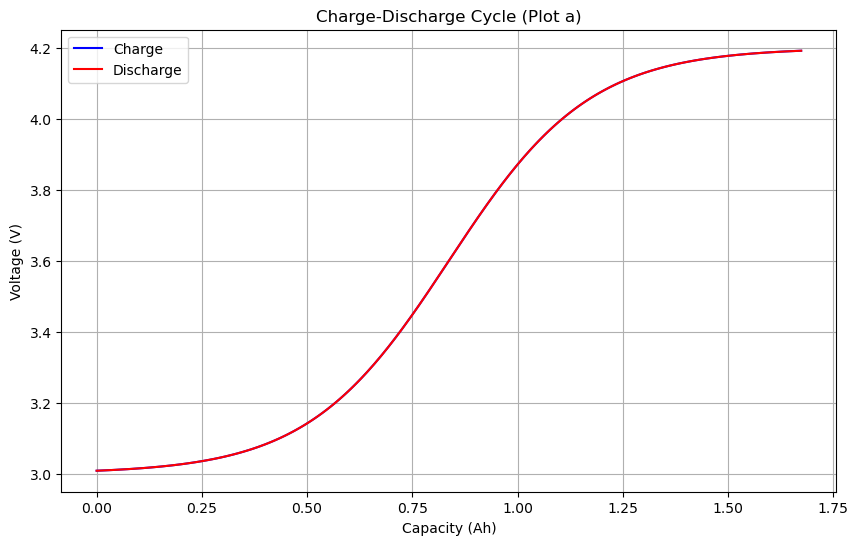

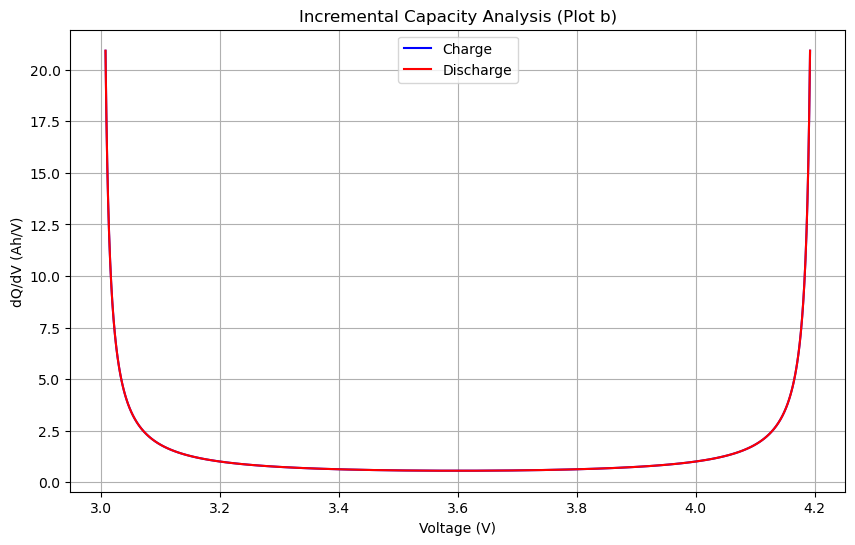

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Simulate a charge-discharge cycle (V vs. Q)
def simulate_charge_discharge_cycle(capacity_max=1.674, v_min=3.0, v_max=4.2, points_per_cycle=500):
    """
    Simulate a V vs. Q curve for a charge-discharge cycle.
    
    Args:
        capacity_max (float): Maximum capacity in Ah (e.g., 1.674 Ah from dataset).
        v_min (float): Minimum voltage in V (e.g., 3.0V).
        v_max (float): Maximum voltage in V (e.g., 4.2V).
        points_per_cycle (int): Number of data points per cycle (charge or discharge).
    
    Returns:
        pandas.DataFrame: DataFrame with 'Q' (capacity), 'V' (voltage), and 'Stage' (charge/discharge).
    """
    # Simulate charging (Q from 0 to capacity_max, V from v_min to v_max)
    q_charge = np.linspace(0, capacity_max, points_per_cycle)
    # Logistic function to simulate V vs. Q (charging)
    v_charge = v_min + (v_max - v_min) / (1 + np.exp(-10 * (q_charge / capacity_max - 0.5)))
    
    # Simulate discharging (Q from capacity_max to 0, V from v_max to v_min)
    q_discharge = np.linspace(capacity_max, 0, points_per_cycle)
    v_discharge = v_min + (v_max - v_min) / (1 + np.exp(-10 * (q_discharge / capacity_max - 0.5)))
    
    # Combine data
    q = np.concatenate([q_charge, q_discharge])
    v = np.concatenate([v_charge, v_discharge])
    stage = ['Charge'] * points_per_cycle + ['Discharge'] * points_per_cycle
    
    return pd.DataFrame({'Q': q, 'V': v, 'Stage': stage})

# Compute dQ/dV and plot ICA
def plot_ica(cycle_data):
    """
    Compute and plot dQ/dV vs. V for a charge-discharge cycle.
    
    Args:
        cycle_data (pandas.DataFrame): DataFrame with 'Q', 'V', and 'Stage' columns.
    
    Returns:
        tuple: (fig1, fig2) - Plot (a) and Plot (b) figures.
    """
    # Separate charge and discharge
    charge_data = cycle_data[cycle_data['Stage'] == 'Charge']
    discharge_data = cycle_data[cycle_data['Stage'] == 'Discharge']
    
    # Plot (a): V vs. Q
    fig1 = plt.figure(figsize=(10, 6))
    plt.plot(charge_data['Q'], charge_data['V'], label='Charge', color='blue')
    plt.plot(discharge_data['Q'], discharge_data['V'], label='Discharge', color='red')
    plt.xlabel('Capacity (Ah)')
    plt.ylabel('Voltage (V)')
    plt.title('Charge-Discharge Cycle (Plot a)')
    plt.legend()
    plt.grid(True)
    
    # Compute dQ/dV
    # For charging
    v_charge = charge_data['V'].values
    q_charge = charge_data['Q'].values
    dq_dv_charge = np.gradient(q_charge, v_charge)
    # Smooth the derivative to reduce noise
    dq_dv_charge_smooth = savgol_filter(dq_dv_charge, window_length=51, polyorder=3)
    
    # For discharging
    v_discharge = discharge_data['V'].values
    q_discharge = discharge_data['Q'].values
    dq_dv_discharge = np.gradient(q_discharge, v_discharge)
    dq_dv_discharge_smooth = savgol_filter(dq_dv_discharge, window_length=51, polyorder=3)
    
    # Plot (b): dQ/dV vs. V
    fig2 = plt.figure(figsize=(10, 6))
    plt.plot(v_charge, dq_dv_charge_smooth, label='Charge', color='blue')
    plt.plot(v_discharge, dq_dv_discharge_smooth, label='Discharge', color='red')
    plt.xlabel('Voltage (V)')
    plt.ylabel('dQ/dV (Ah/V)')
    plt.title('Incremental Capacity Analysis (Plot b)')
    plt.legend()
    plt.grid(True)
    
    return fig1, fig2

# Simulate and plot
cycle_data = simulate_charge_discharge_cycle()
fig1, fig2 = plot_ica(cycle_data)

# Save and show plots
fig1.savefig('charge_discharge_cycle.png')
fig2.savefig('ica_plot.png')
plt.show()

Random Forest Model:
Mean Absolute Error (MAE): 0.0577 Ah
R² Score: 0.7928

Linear Regression Model:
Mean Absolute Error (MAE): 0.0481 Ah
R² Score: 0.8803


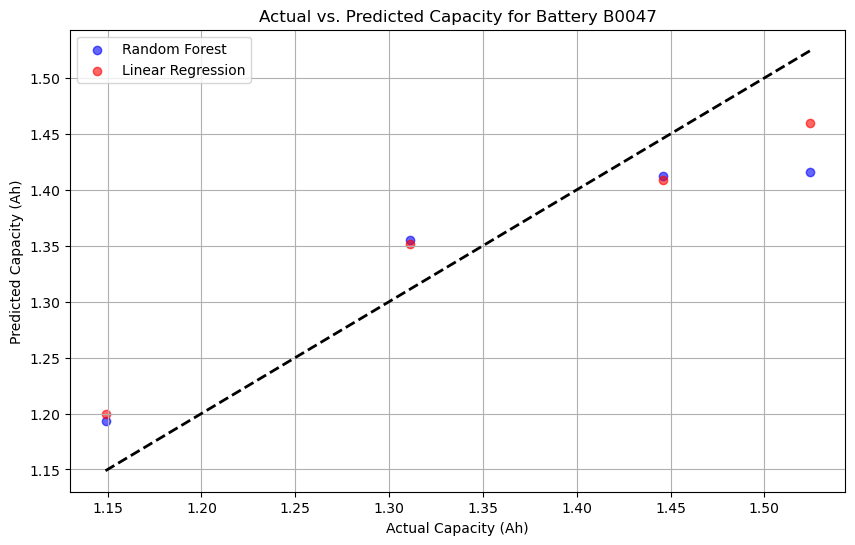

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

def prepare_data(df):
    impedance_data = df[
        (df['type'] == 'impedance') &
        (df['battery_id'] == 'B0047') &
        (df['ambient_temperature'] == 24)
    ].copy()
    
    impedance_data['test_id'] = pd.to_numeric(impedance_data['test_id'], errors='coerce')
    impedance_data['Re'] = pd.to_numeric(impedance_data['Re'], errors='coerce')
    impedance_data['Rct'] = pd.to_numeric(impedance_data['Rct'], errors='coerce')
    impedance_data = impedance_data[['test_id', 'Re', 'Rct']].dropna()
    
    discharge_data = df[
        (df['type'] == 'discharge') &
        (df['battery_id'] == 'B0047')
    ].copy()
    
    discharge_data['test_id'] = pd.to_numeric(discharge_data['test_id'], errors='coerce')
    discharge_data['Capacity'] = pd.to_numeric(discharge_data['Capacity'], errors='coerce')
    discharge_data = discharge_data[['test_id', 'Capacity']].dropna()
    
    impedance_data['test_id_next'] = impedance_data['test_id'] + 1
    
    merged_data = pd.merge(
        discharge_data,
        impedance_data,
        left_on='test_id',
        right_on='test_id_next',
        how='inner'
    )
    
    if merged_data.empty:
        raise ValueError("No matching test_ids found after aligning impedance and discharge data.")
    
    merged_data = merged_data[['test_id_x', 'Re', 'Rct', 'Capacity']].rename(columns={'test_id_x': 'test_id'})
    
    return merged_data

def train_and_evaluate_model(df):
    data = prepare_data(df)
    
    X = data[['Re', 'Rct', 'test_id']]
    y = data['Capacity']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_test)
    
    rf_mae = mean_absolute_error(y_test, rf_predictions)
    rf_r2 = r2_score(y_test, rf_predictions)
    lr_mae = mean_absolute_error(y_test, lr_predictions)
    lr_r2 = r2_score(y_test, lr_predictions)
    
    print("Random Forest Model:")
    print(f"Mean Absolute Error (MAE): {rf_mae:.4f} Ah")
    print(f"R² Score: {rf_r2:.4f}")
    print("\nLinear Regression Model:")
    print(f"Mean Absolute Error (MAE): {lr_mae:.4f} Ah")
    print(f"R² Score: {lr_r2:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, rf_predictions, color='blue', label='Random Forest', alpha=0.6)
    plt.scatter(y_test, lr_predictions, color='red', label='Linear Regression', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Capacity (Ah)')
    plt.ylabel('Predicted Capacity (Ah)')
    plt.title('Actual vs. Predicted Capacity for Battery B0047')
    plt.legend()
    plt.grid(True)
    plt.savefig('capacity_predictions.png')
    plt.show()
    
    return rf_model, lr_model, X_test, y_test, rf_predictions, lr_predictions

try:
    rf_model, lr_model, X_test, y_test, rf_predictions, lr_predictions = train_and_evaluate_model(df)
except NameError:
    print("Error: DataFrame 'df' is not defined. Please load the data first using df = pd.read_csv('metadata.csv').")